In [1]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from matplotlib import colors, cm, ticker
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import AxesGrid
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

In [2]:
def bruteforce_to_dict(data):
    assert data.ndim == 2 and data.shape[1]
    if data.shape[1] == 1:
        assert data[:, 0].size == 1
        return float(data[0, 0])
    output = {}
    for value in np.unique(data[:, 0]):
        output[value] = bruteforce_to_dict(data[data[:, 0] == value, 1:])
    return output

In [3]:
def print_dict(data, level=0):
    space = ' ' * level
    if isinstance(data, float):
        print('{}{}'.format(space, data))
    elif isinstance(data, dict):
        for key, value in sorted(data.items(), key=lambda x: x[0]):
            print('{}{}:'.format(space, key))
            print_dict(value, level + 1)
    else:
        assert False

In [4]:
def get_deepness(data, level=0):
    if isinstance(data, float):
        return level
    return get_deepness(list(data.values())[0], level + 1)

In [5]:
def flatten_dict(data):
    if isinstance(data, float):
        return ([data], )
    result = [[] for _ in range(get_deepness(data) + 1)]
    for key in data:
        tmp = flatten_dict(data[key])
        result[0] += [key] * len(tmp[0])
        for i in range(len(tmp)):
            result[i+1] += tmp[i]
    return result

In [6]:
def draw(plot, norm, data, X_grid, Y_grid, annotate=False):
    y, x, z = data
    min_index = np.argmin(z)
    x_min, y_min, z_min = x[min_index], y[min_index], z[min_index]
    y_text = -1.5 if y_min > 0 else 1.5
    y_text /= 2
    x_text = -2.5 + 2.75
    if annotate:
        plot.annotate('min %2.2f' % z_min, xy=(x_min, y_min), xytext=(x_text, y_text),
                       arrowprops=dict(facecolor='black', arrowstyle='->'))
    Z = griddata(x, y, z, X_grid, Y_grid, interp='linear')
    return plot.pcolormesh(X_grid, Y_grid, Z, cmap=cm.jet_r, norm=norm)

In [7]:
def draw_grid(axes, data, norm, X, Y, z):
    if get_deepness(data) == 2:
        current_data = flatten_dict(data)
        return draw(axes[0], norm, current_data, X, Y, np.allclose(min(current_data[-1]), min(z)))
    for i, (key, value) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        axes_amount = len(axes) // len(data)
        result = draw_grid(axes[axes_amount * i: axes_amount * (i + 1)], value, norm, X, Y, z)
    return result

In [8]:
def draw_topology(data, X, Y, grid_size=None):
    if grid_size is None:
        if get_deepness(data) == 3:
            grid_size = (1, len(data))
        if get_deepness(data) == 4:
            grid_size = (len(data[list(data.keys())[0]]), len(data))
    if get_deepness(data) == 4:
        assert (len(data[list(data.keys())[0]]) - 1) % (grid_size[1] - 1) == 0
        assert (len(data) - 1) % (grid_size[0] - 1) == 0
        steps = ((len(data) - 1) // (grid_size[0] - 1), (len(data[list(data.keys())[0]]) - 1) // (grid_size[1] - 1))
    elif get_deepness(data) == 3:
        assert (len(data) - 1) % (grid_size[1] - 1) == 0
        steps = (len(data) - 1) // (grid_size[1] - 1)
    else:
        assert False, 'Unable to draw plot with {} dimensions'.format(get_deepness(data))

    z = np.unique(flatten_dict(data)[-1])
    norm = colors.Normalize(vmin=z.min(), vmax=z.max())
    fig = plt.figure()
    axes = AxesGrid(fig, 111, nrows_ncols=grid_size,
                    axes_pad=0.3,
                    share_all=True,
                    label_mode="L",
                    cbar_location="right",
                    cbar_mode="single")

    if get_deepness(data) == 4:
        data = {key1: {key2: data[key1][key2]
                       for key2 in list(sorted(data[key1].keys()))[::steps[1]]}
                for key1 in list(sorted(data.keys()))[::steps[0]]}
    elif get_deepness(data) == 3:
        data = {key1: data[key1] for key1 in list(sorted(data.keys()))[::steps]}
    else:
        assert False

    for i, key in enumerate(sorted(data.keys())):
        if get_deepness(data) > 3:
            axes[i  * grid_size[1]].set_ylabel('Fourth = %2.2f' % key)
        else:
            axes[i].set_title('Third = %2.2f' % key)

    if get_deepness(data) > 3:
        for i, key in enumerate(sorted(data[list(data.keys())[0]].keys())):
            axes[i].set_title('Third = %2.2f' % key)

    axes.cbar_axes[0].colorbar(draw_grid(axes, data, norm, X, Y, z))
    plt.show()

In [9]:
def preprocess_raw_data(filename, drop_columns=()):
    assert isinstance(drop_columns, tuple)
    raw_data = np.load(filename)
    if drop_columns:
        data_mask = raw_data[:, drop_columns] == raw_data[:, drop_columns][raw_data[:, -1].argmin()]
        raw_data = np.delete(raw_data[data_mask.all(axis=1)], drop_columns, axis=1)
    assert 3 < raw_data.shape[1] < 6
    X, Y = np.meshgrid(np.linspace(min(raw_data[:, 0]), max(raw_data[:, 0]), 100),
                       np.linspace(min(raw_data[:, 1]), max(raw_data[:, 1]), 100))
    data = raw_data.copy()
    for i in range(raw_data.shape[1] - 1):
        data[:, i] = raw_data[:, raw_data.shape[1] - 2 - i]
    return bruteforce_to_dict(data), X, Y

In [10]:
def process_file(filename, names=(), drop_columns=()):
    draw_topology(*preprocess_raw_data(filename, drop_columns))

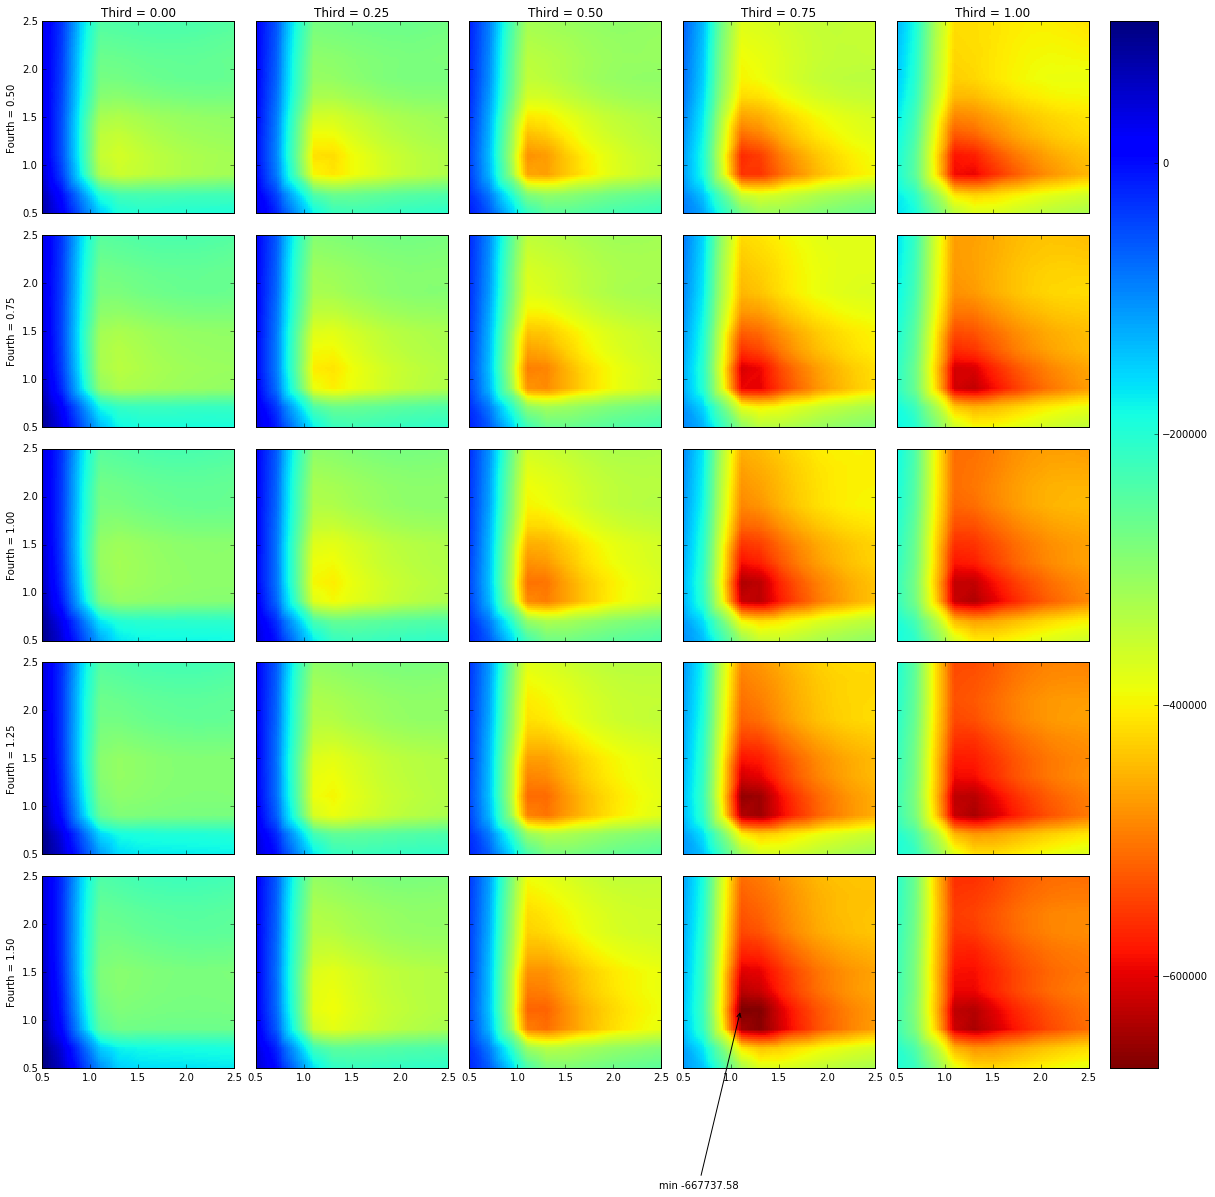

In [11]:
process_file('light_scale_sasha.npy', names=('Scale x', 'Scale y', 'Light alpha', 'Scale z'), drop_columns=(0, 1))

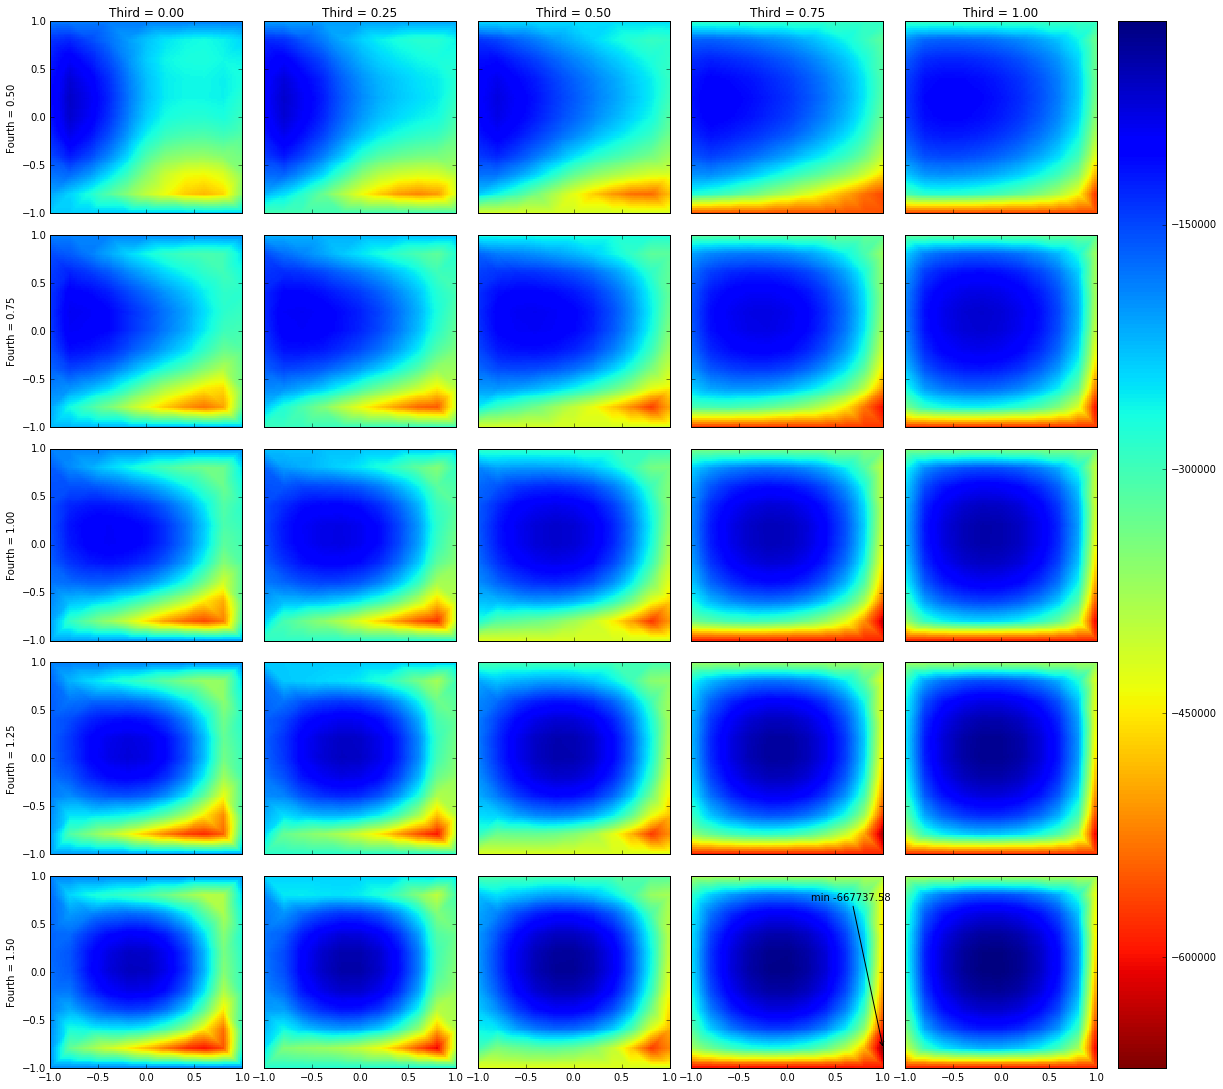

In [12]:
process_file('light_scale_sasha.npy', names=('Light x', 'Light y', 'Light alpha', 'Scale z'), drop_columns=(2, 3))

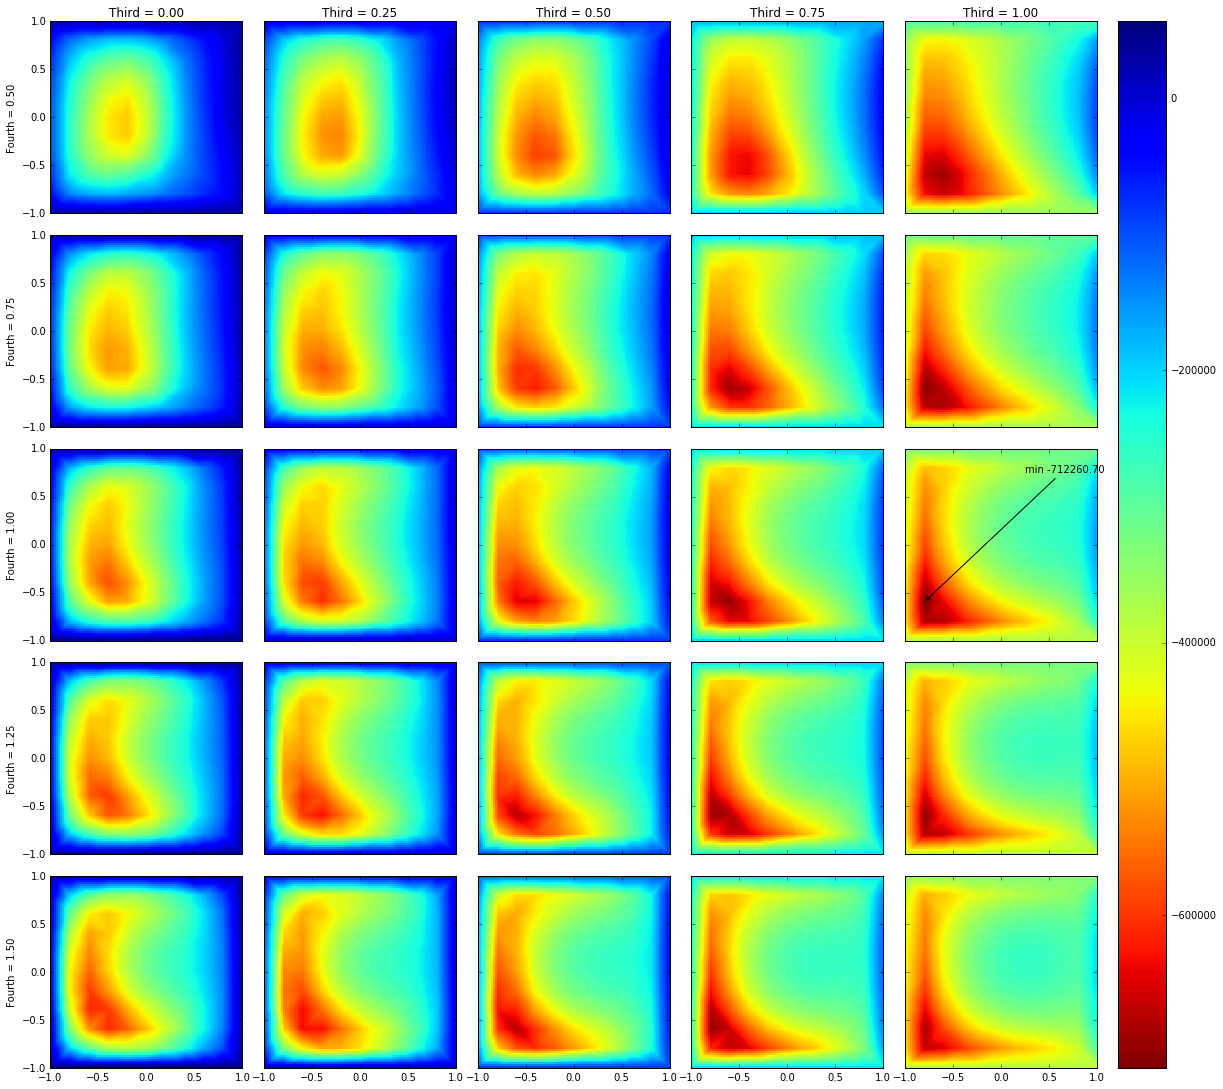

In [13]:
process_file('light_test_004.npy')

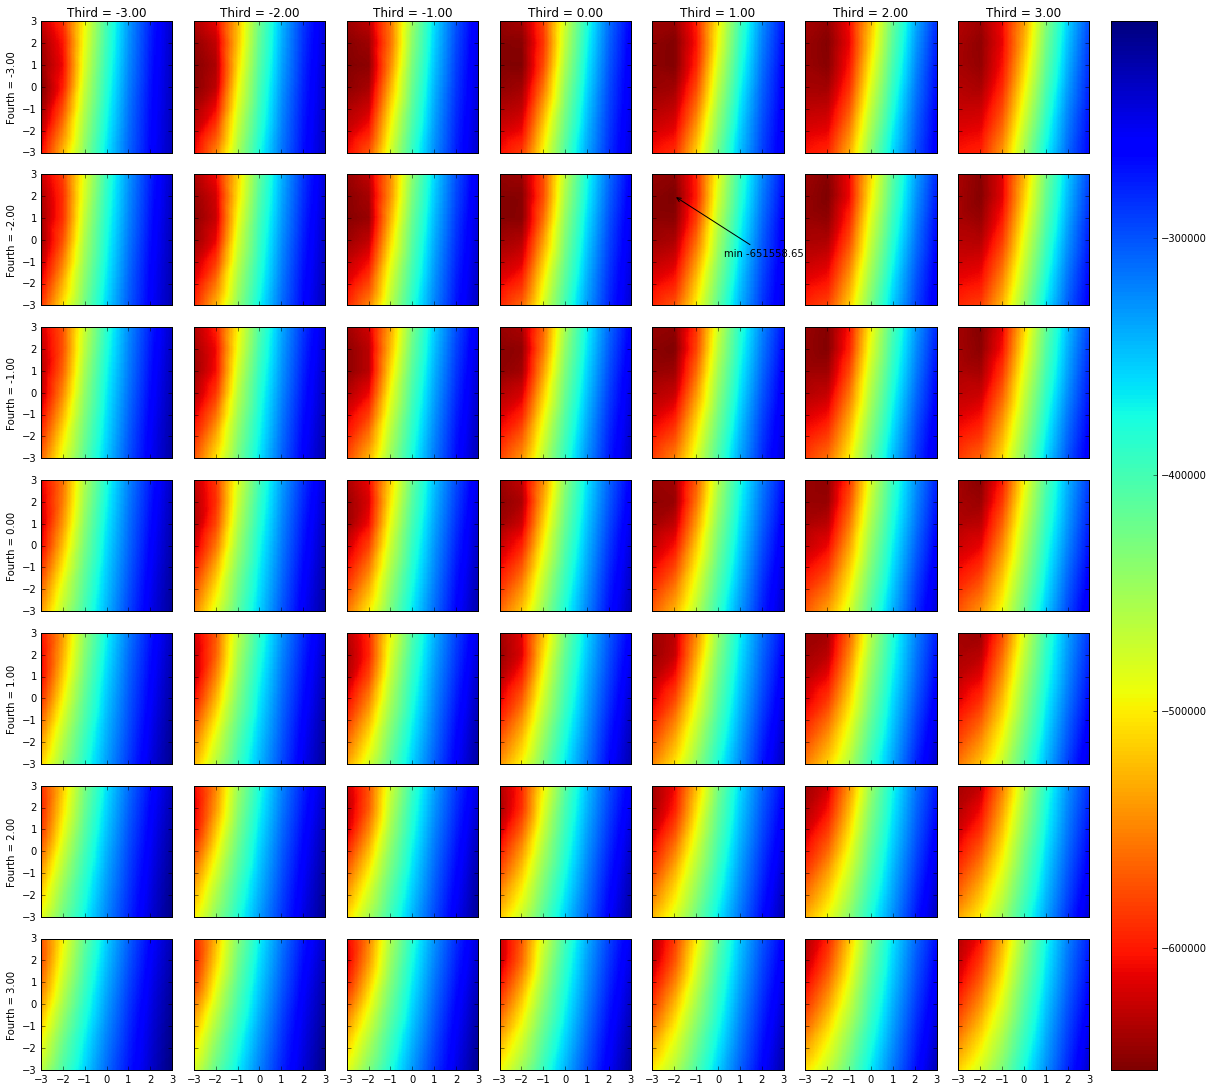

In [14]:
process_file('topology.npy')